In [ ]:
Мышковец С.А., v.1 03.01.2023

Решение задачи:

Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года. 

Вывод:

| Method | 1st month | 2 years | RMSE on test
| ----------- | ----------- | ----------- | -----------
| Moving average | 8797 | - | -
| Weighted average | 9507 | - | -
| Holt-Winters | 8542 | 216884 | 596
| SARIMA | 8246 | 225722 | 243
| Feature extraction | 8159 | 212117 | 349
| XGBoost | 8159 | 212117 | 350
| NeuralProphet | 8190 | 223034 | 889 (281)
| Prophet | 8131 | 221406 | 932


Попробовав разные методы и подходами к анализу и прогнозированию временных рядов, можно отметить, что большого разбега в результатах нет.

Предсказания моделями XGBoost и Feature extraction практически совпали.

Лучшую метрику RMSE показала SARIMA-модель, хотя подбор параметров требует наибольших трудозатрат.

Сравнительный график моделей можно увидеть в конце работы.

Не понятна ситуация с метрокой RMSE в модели NeuralProphet - метрика, предоставленная моделью, не совпадает с посчитанной вручную.

**Импортируем нужные библиотеки.**

In [111]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [2]:
import os
import seaborn as sns 
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

**Загрузим данные.**

In [3]:
deaths = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])

In [4]:
deaths.head()

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017


In [5]:
deaths.tail()

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1978-08-01,9827
1978-09-01,9110
1978-10-01,9070
1978-11-01,8633
1978-12-01,9240


In [6]:
deaths['deaths'] = deaths['Accidental deaths in USA: monthly, 1973 ? 1978']
deaths = deaths.drop(['Accidental deaths in USA: monthly, 1973 ? 1978'], axis=1)
plotly_df(deaths, title = "accidental-deaths")

In [7]:
deaths.describe()

,deaths
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


In [8]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1973-01-01 to 1978-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   deaths  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


---

# Движение и сглаживание.

In [9]:
def moving_average(series, n):
    return np.average(series[-n:])

**Посмотрим на прогноз на следующий месяц, построенный по последнему наблюдаемому году (12 месяцев).**

In [10]:
moving_average(deaths.deaths, 12) 

8796.75

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов: чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены такая процедура может помочь увидеть общие паттерны.

In [11]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean()
    
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

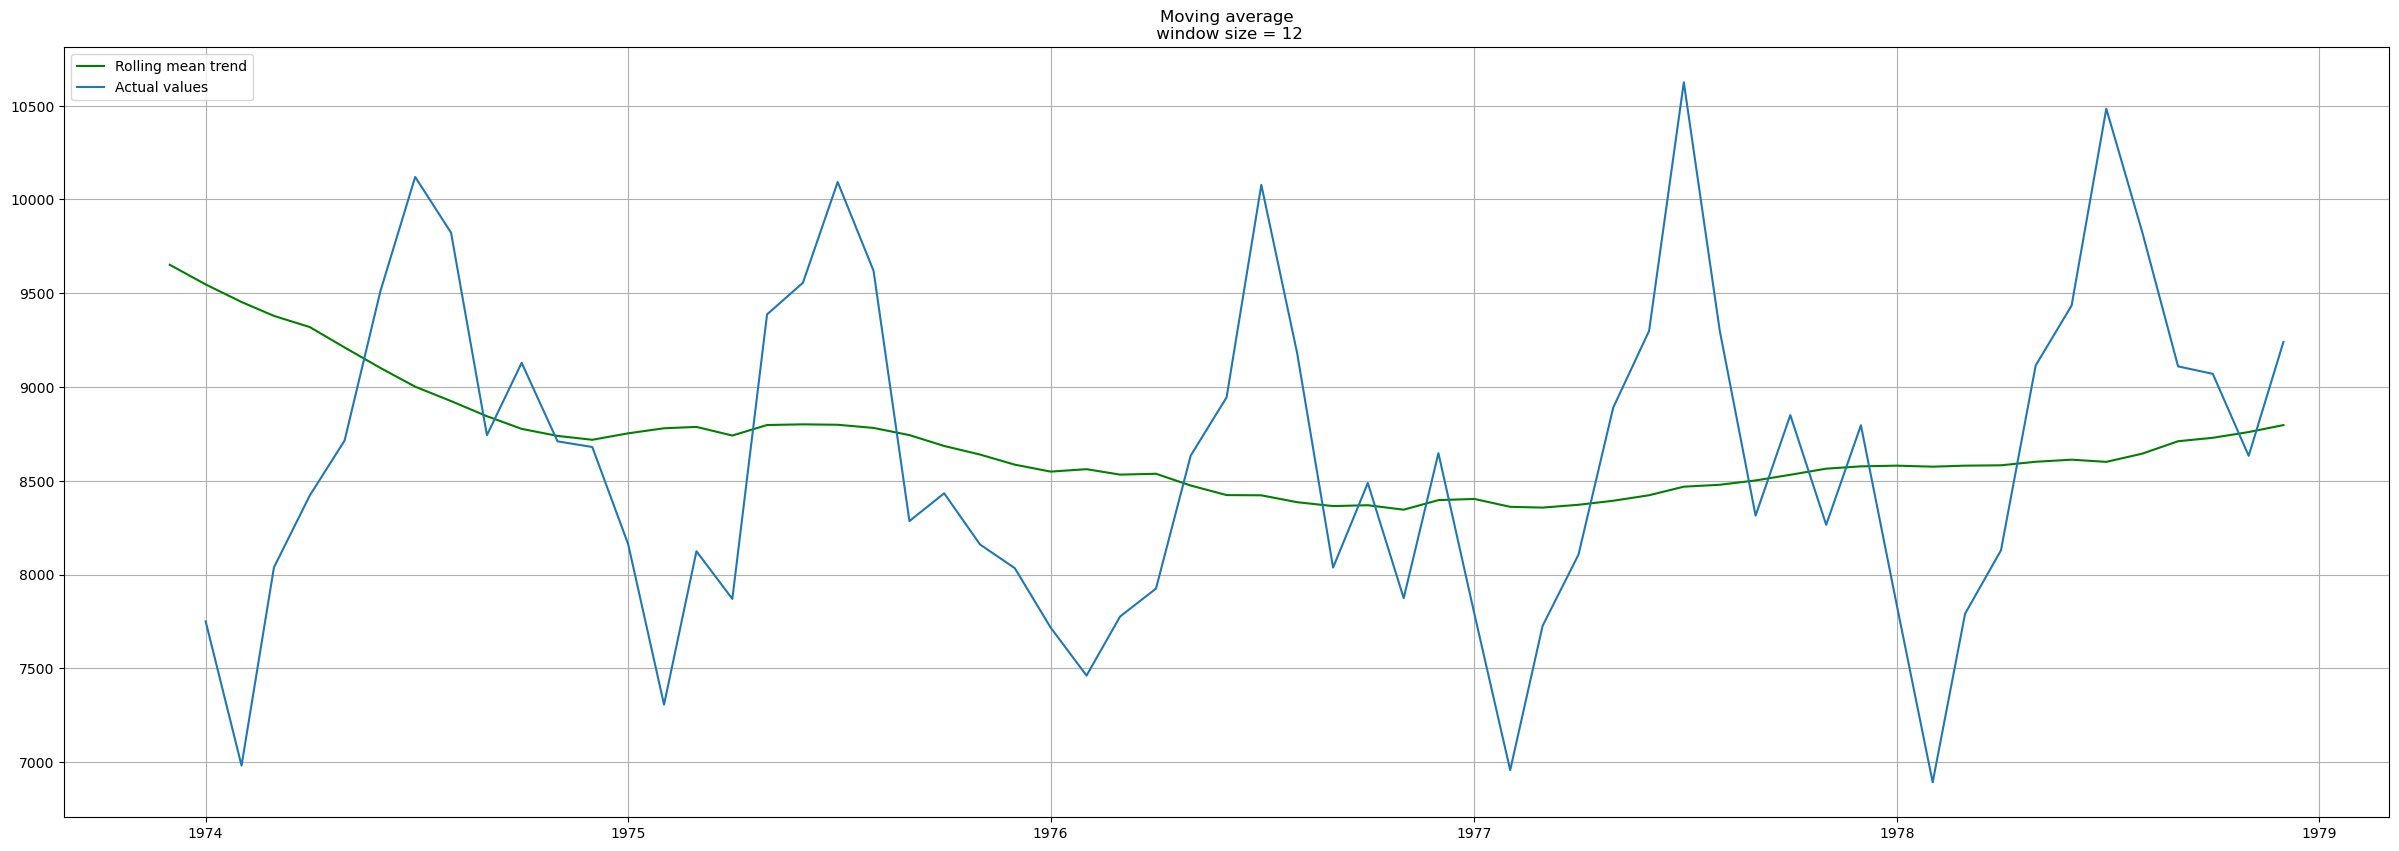

In [12]:
plotMovingAverage(deaths, 12) # сглаживаем по годам

Для нашего ряда сезонность вполне очевидна, но если сгладить по годам, становится лучше видна общая динамика.

In [13]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

**Предскажем значение на следующий месяц.**

In [14]:
weighted_average(deaths.deaths, [0.6, 0.2, 0.1, 0.07, 0.03])
#В данной функции мы получаем последние 5 значений умноженные на соответствующий вес. Вес мы взяли условно случайно. 

9506.71

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

In [18]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [19]:
from sklearn.model_selection import TimeSeriesSplit
counter = 0
def timeseriesCVscore(x):
    global counter
    counter+=1

    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen = 6, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [20]:
%%time
data = deaths.deaths[:-24] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

#TNC - Минимизируйте скалярную функцию одной или нескольких переменных, используя усеченный алгоритм Ньютона (TNC). 
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

1.0 0.01405900369583496 0.10147945617279042
CPU times: user 333 ms, sys: 13.7 ms, total: 347 ms
Wall time: 337 ms


In [21]:
opt

     fun: 618886.7856287082
     jac: array([-1.91517872e+05, -1.16415322e-02,  0.00000000e+00])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 252
     nit: 16
  status: 1
 success: True
       x: array([1.        , 0.014059  , 0.10147946])

Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 2 года вперёд (24 месяца) в пределах тестовой выборки с метками.

In [22]:
# Передаем оптимальные значения модели, 
data = deaths.deaths
model = HoltWinters(data[:-24], slen = 12, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 24, scaling_factor = 2.56)
model.triple_exponential_smoothing()

**Посчитаем RMSE.**

In [23]:
print(mean_squared_error(data.values[-24:],model.result[-24:])**0.5)

596.6214450551213


In [24]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-24, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

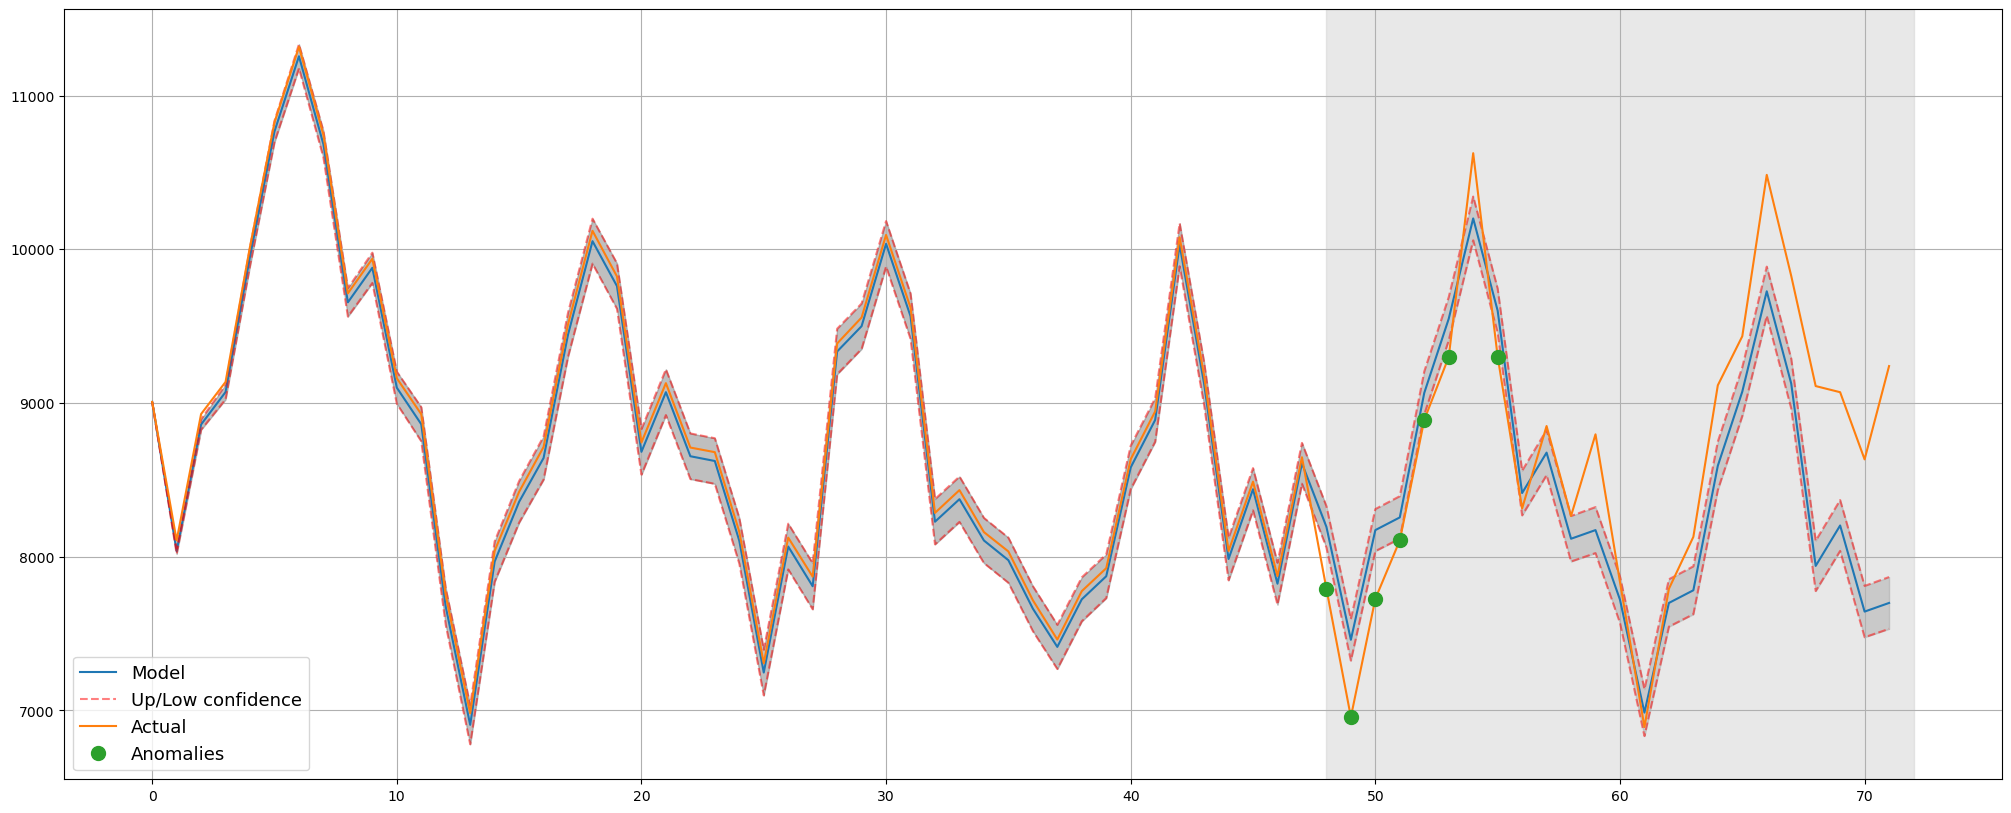

In [25]:
plotHoltWinters()

Судя по графику, модель описала исходный временной ряд не совсем точно, но уловила годовую сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. 

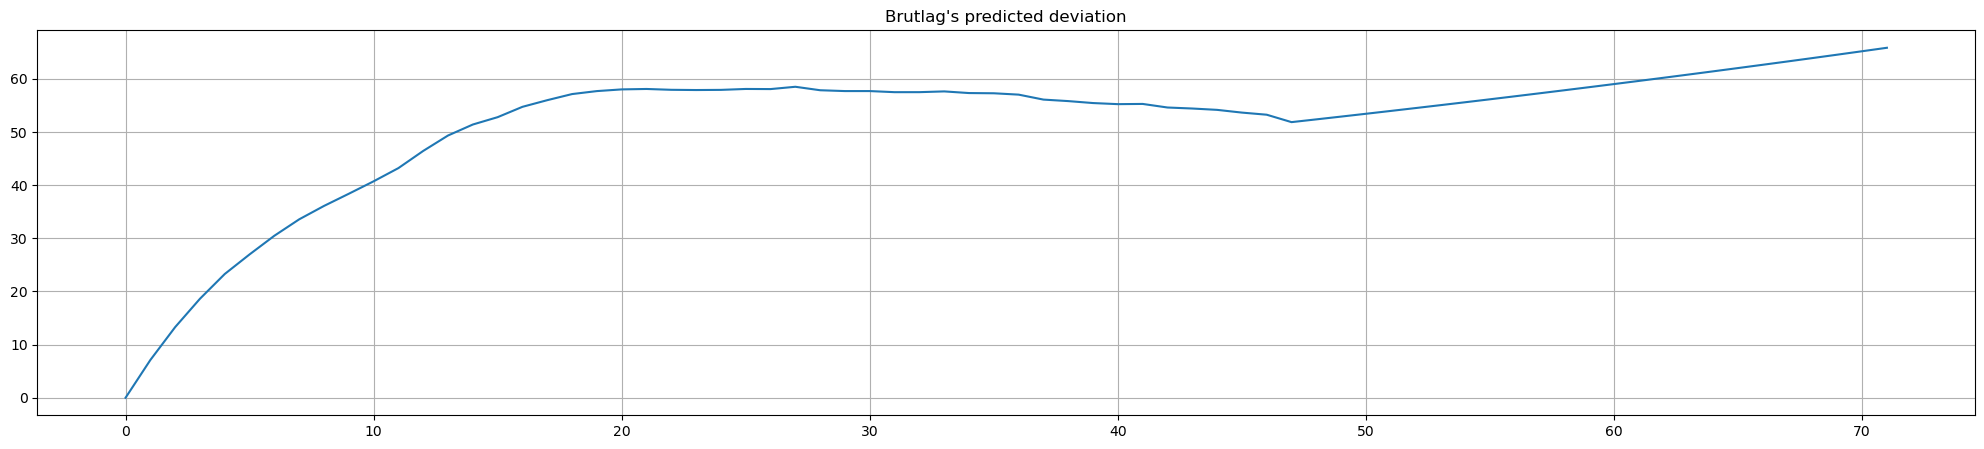

In [26]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

**Предскажем количество смертей на следующие 2 года.**

In [27]:
model = HoltWinters(
    data, 
    slen = 12, 
    alpha = alpha_final, beta = beta_final, gamma = gamma_final, 
    n_preds = 24, 
    scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [28]:
prediction_hw = model.result[-24:]

**Посморим значение на первый следующий месяц.**

In [29]:
model.result[-24:-23]

[8541.71603969827]

**Сумма на следующие 2 года.**

In [30]:
sum(model.result[-24:])

216884.47857614767

**Модель предсказала 216884 смертей на следующие 2 года.**

---

# Эконометрический подход

In [31]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(deaths)

## Избавляемся от нестационарности и строим SARIMA

In [32]:
def series_decomposition(series, method='additive'):
    result = seasonal_decompose(series, model=method)
    result.plot()
    plt.show()

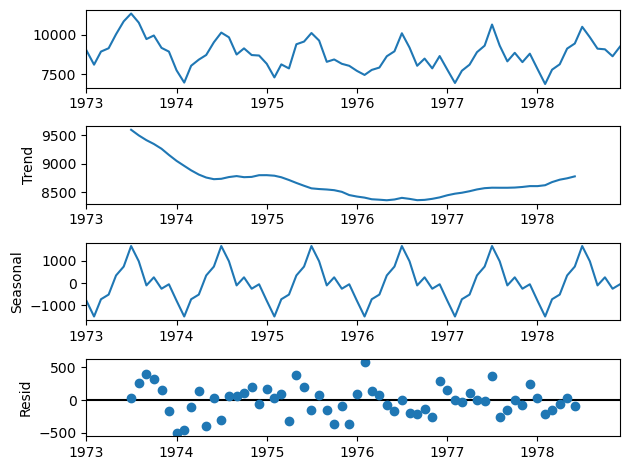

In [33]:
series_decomposition(deaths)

Как предполагалось, у нас "линейный"тренд и сезонная зависимость в 12 месяцев (год).
Проверим на стационарность.

In [34]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]<0.05:
        print('Time Series is stationary')
    else: 
        print('Time Series is not stationary')

In [35]:
check_stationarity(deaths)

ADF Statistic: -2.555798
p-value: 0.102481
Time Series is not stationary


Наш временной ряд стационарен и имеет тренд и сезонную зачисимость. В связи с этим выбираем модель SARIMAX. Нам надо определить следующие параметры: SARIMAX=(p,d,q)x(P,D,Q,m) Where :

- p is the Auto-Regressive Component,
- d is the order of the differenciation used to eliminate the trend,
- q is the Moving-Average Component,
- P is the Seasonal-Auto-Regressive Component,
- D is the order of the Seasonal differenciation,
- Q is the Seasonal-Moving-Average Component, and
- m is the Seasonal-Period

Изменим наш временной ряд.

In [36]:
def plot_acf_pacf_graphs(series):
    fig, ax = plt.subplots(2,1)
    fig = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax[1])
    plt.tight_layout()
    plt.show()

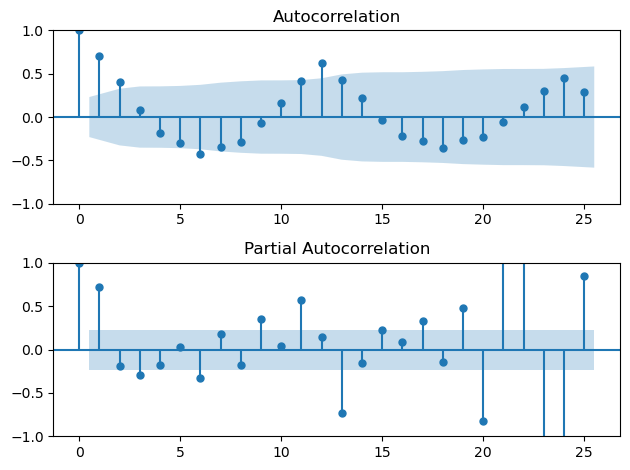

In [37]:
plot_acf_pacf_graphs(deaths)

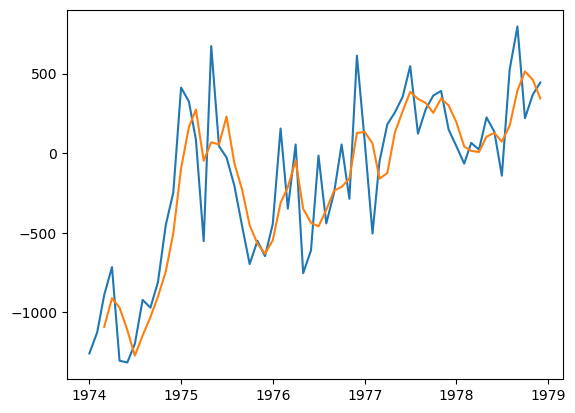

In [38]:
plt.plot(deaths.diff(12))
plt.plot(deaths.diff(12).rolling(window=3).mean())
plt.show()

Здесь мы убрали компонент сезонности, но тренд еще сохранился. Продолжим видоизменение ряда.

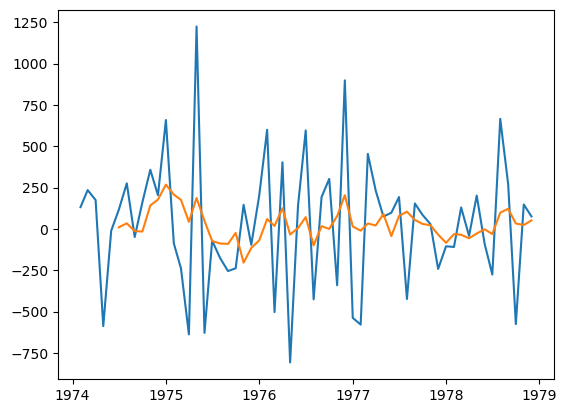

In [39]:
plt.plot(deaths.diff(12).diff(1))
plt.plot(deaths.diff(12).diff(1).rolling(window=6).mean())
plt.show()

Сейчас ряд выглядит стационарным, проверим это. 

In [40]:
check_stationarity(deaths.diff(12).diff(1).dropna())

ADF Statistic: -7.937464
p-value: 0.000000
Time Series is stationary


Временной ряд стал стационарным.Значит, мы нашли следующие параметры:

m = 12
d = 1
D = 1

 **Ищем остальные параметры.**

In [41]:
diff_dataset = deaths.diff(12).diff(1).dropna()

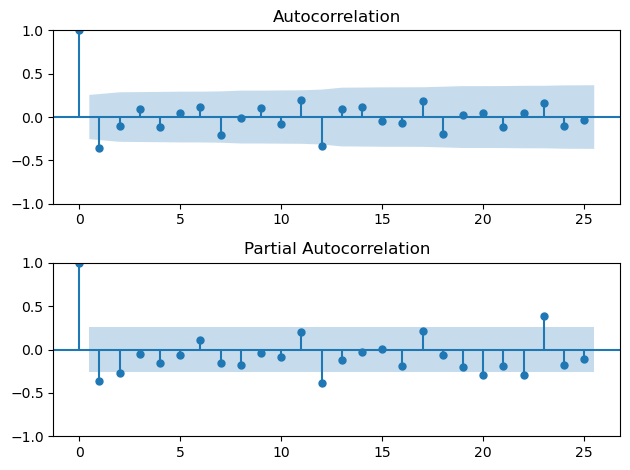

In [42]:
plot_acf_pacf_graphs(diff_dataset)

Остальные параметры не так очевидны. Посморим на  ACF и PACF, чтобы попробовать их определить. Мы смотрим на кратные сезонности для определения сезонного компанента (у нас это 12 и 24) и на  лаги низкого ранга для компонентов ARIMA.

- ACF: значительных лагов низкого уровня мало (1, 12). Пусть q = 1.
- ACF: По поводу лага 12 можно поспорить, мы можем применить как 0, так и 1. Начнем с Q=0.
- PACF: начительных лагов низкого уровня мало (1, 2, 12). Пусть p = 1.
- PACF: Лаги 12 и 24 мы можем применить как 0, так и 1. Начнем с P=0.

SARIMAX=(p,d,q)x(P,D,Q,m)

Получаем следующую модель SARIMAX=(1,1,1)x(0,1,0,12).

In [43]:
def sarimax_modeling(series, params, s_params):
    model = sm.tsa.statespace.SARIMAX(series, order=params, 
                                      seasonal_order=s_params).fit(max_iter=50, method='powell')
    print('SARIMAX{}x{} - AIC:{}'.format(params, s_params, model.aic))
    print(model.summary())
    model.plot_diagnostics(figsize=(18, 8))
    plt.show()

Optimization terminated successfully.
         Current function value: 5.912291
         Iterations: 2
         Function evaluations: 95
SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:859.3699685270105
                                      SARIMAX Results                                      
Dep. Variable:                              deaths   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -425.685
Date:                             Wed, 04 Jan 2023   AIC                            859.370
Time:                                     00:46:39   BIC                            867.680
Sample:                                 01-01-1973   HQIC                           862.614
                                      - 12-01-1978                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      

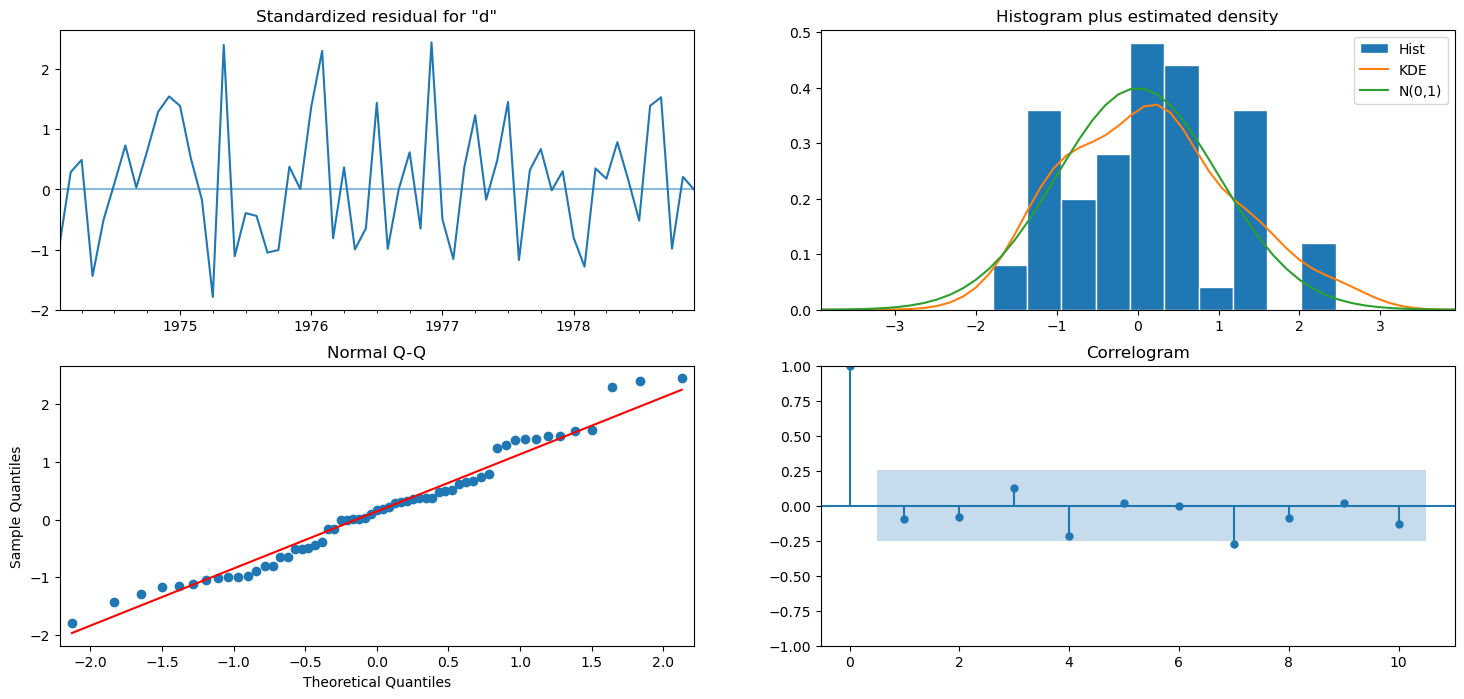

In [112]:
sarimax_modeling(deaths, params=(1,1,1), s_params=(1,1,0,12))

Проверим, как модель предсказывает и проверим качество ее работы (walk-forward validation).

In [45]:
def sarimax_prediction(series, params, s_params, start_point):
    model = sm.tsa.statespace.SARIMAX(series, order=params, 
                                      seasonal_order=s_params).fit(max_iter=50, method='powell', disp=False)
    pred = model.get_prediction(start=start_point, dynamic=False)
    pred_ci = pred.conf_int()
    ax = series.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Quantity')
    plt.legend()
    plt.show()

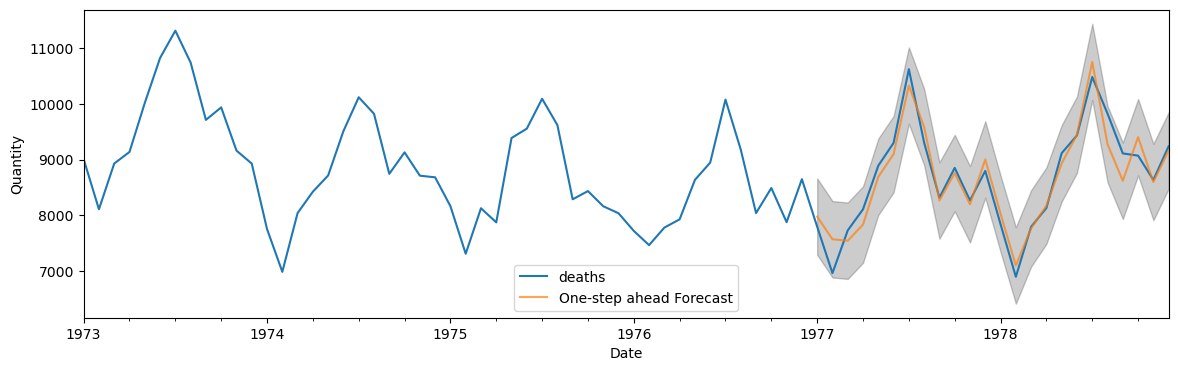

In [113]:
sarimax_prediction(deaths, params=(1,1,1), s_params=(0,1,0,12), start_point=pd.to_datetime('01-01-1977'))

**Похоже, что предсказанные значения довольно точны.**

In [47]:
def sarimax_walk_forward_validation(series, params, s_params, test_size):
    n_train = int(len(series) * (1-test_size))
    train, test = series.values[0:n_train], series.values[n_train:len(series)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=params, seasonal_order=s_params)
        model_fit = model.fit(max_iter=50, method='powell', disp=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

Test RMSE: 243.687


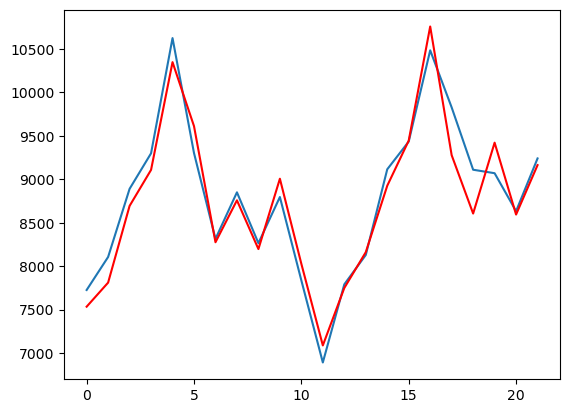

In [48]:
sarimax_walk_forward_validation(deaths,params=(1,1,1), s_params=(0,1,0,12), test_size=0.3)

**Предскажем значения на следующие 2 года.**

In [49]:
def sarimax_walk_forward_forecast(series, params, s_params, steps=5):
    history = series.copy()
    predictions = [history.iloc[-1]]
    predictions_ci_min = [history.iloc[-1]]
    predictions_ci_max = [history.iloc[-1]]
    predictions_ci_index = [history.index[-1]]
    for t in range(steps):
        model = sm.tsa.statespace.SARIMAX(history, order=params, seasonal_order=s_params)
        model_fit = model.fit(max_iter=50, method='powell', disp=False)
        predictions.append(model_fit.get_forecast().predicted_mean[0])
        predictions_ci_min.append(model_fit.get_forecast().conf_int().values[0,0])
        predictions_ci_max.append(model_fit.get_forecast().conf_int().values[0,1])
        predictions_ci_index.append(model_fit.get_forecast().conf_int().index.tolist()[0])
        history = history.append(model_fit.get_forecast().predicted_mean)
    plt.figure(figsize=(14, 4))
    plt.plot(predictions_ci_index, predictions, label='Walk-Forward ahead Forecast', alpha=.7, color='red')
    plt.plot(series, label='observed', color='blue')
    plt.fill_between(predictions_ci_index, predictions_ci_min, predictions_ci_max, color='k', alpha=.2)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()
    print(predictions[-24:-23])
    prediction_sarima = predictions[-24:]
    print(sum(predictions[-24:]))
    return prediction_sarima

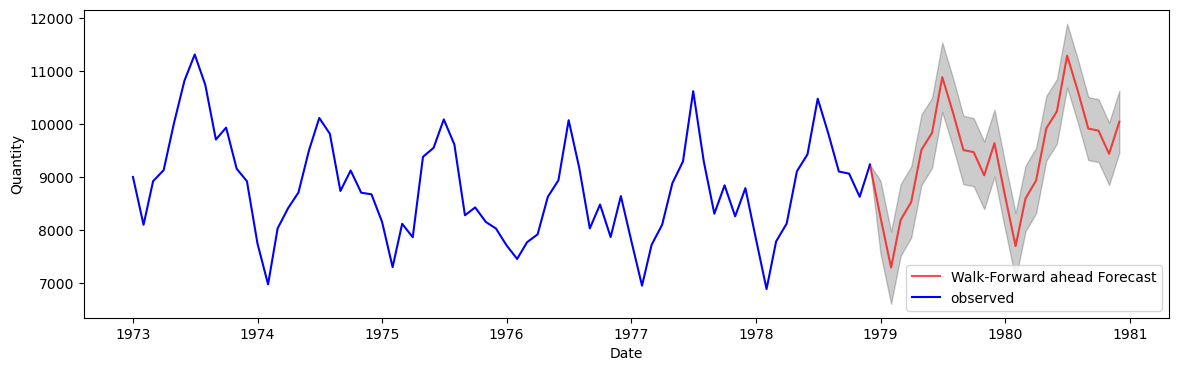

[8246.482184122668]
225722.05605424402


[8246.482184122668,
 7297.921642593992,
 8196.32227788005,
 8534.236999280478,
 9520.223572130928,
 9839.220423379042,
 10889.219327067594,
 10232.218779445448,
 9515.218488245837,
 9475.21833079609,
 9038.21824526413,
 9645.218198719775,
 8651.700357489039,
 7703.13980213918,
 8601.54043100127,
 8939.455278204328,
 9925.44186518623,
 10244.438717667048,
 11294.437621265133,
 10637.43707350511,
 9920.436782257819,
 9880.436624760887,
 9443.436539200904,
 10050.436492641078]

In [114]:
sarimax_walk_forward_forecast(deaths['deaths'],params=(1,1,1), s_params=(0,1,0,12), steps=24)

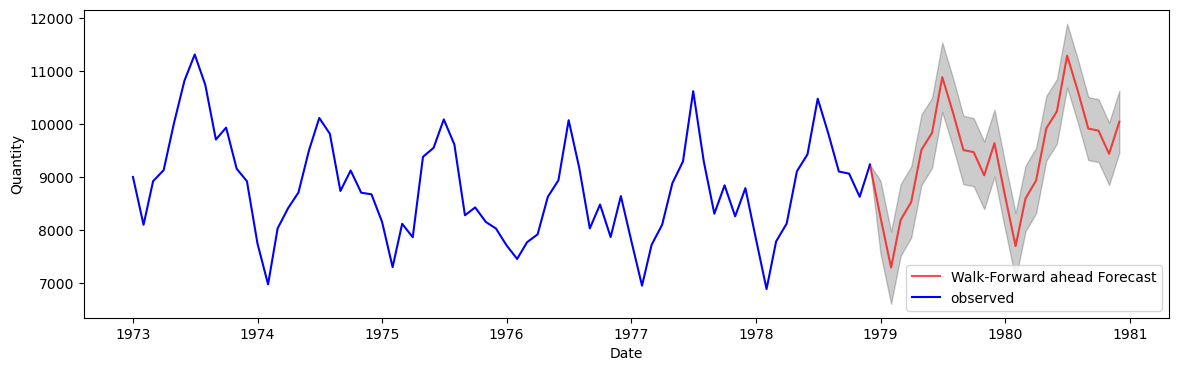

[8246.482184122668]
225722.05605424402


In [115]:
prediction_sarima = sarimax_walk_forward_forecast(deaths['deaths'],params=(1,1,1), s_params=(0,1,0,12), steps=24)

**Модель предсказала 225722 на следующие 2 года.**

---

# Линейная регрессия. Извлечение признаков (Feature exctraction)

In [52]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим новый датафрейм и добавим в него месяц в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `month`.

In [53]:
data = pd.DataFrame(deaths.copy())
data.columns = ["y"]

#data.index = data.index.to_datetime()
data["month"] = data.index.month
data.head()

,y,month
Month,,
1973-01-01,9007,1
1973-02-01,8106,2
1973-03-01,8928,3
1973-04-01,9137,4
1973-05-01,10017,5


Посмотрим на средние по месяцам.

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [54]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    #data.index = data.index.to_datetime()
    data["month"] = data.index.month

    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))

    # выкидываем закодированные средними признаки 
    data.drop(["month"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Обучим на получившихся данных простую линейную регрессию. При этом лаги будем брать начиная с 5, таким образом модель будет способна строить предсказания на 5 месяцев вперёд, имея фактические наблюдения за почти предыдущие полгода.

In [55]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(deaths, test_size=0.45, lag_start=5, lag_end=10)

In [56]:
X_train.head()

,lag_5,lag_6,lag_7,lag_8,lag_9,month_average
0,10017.0,9137.0,8928.0,8106.0,9007.0,9166.666667
1,10826.0,10017.0,9137.0,8928.0,8106.0,8677.000000
2,11317.0,10826.0,10017.0,9137.0,8928.0,8547.000000
3,10744.0,11317.0,10826.0,10017.0,9137.0,8159.000000
4,9713.0,10744.0,11317.0,10826.0,10017.0,7463.500000


In [57]:
y_train[:5]

0    9938
1    9161
2    8927
3    7750
4    6981
Name: y, dtype: int64

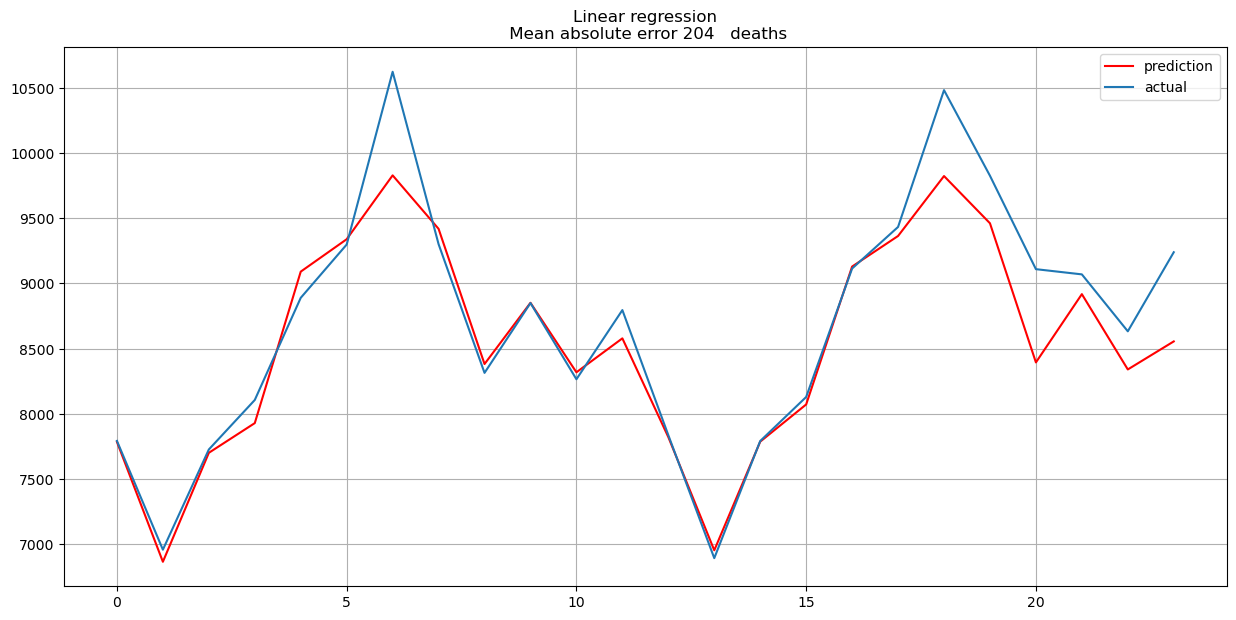

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}   deaths".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [59]:
from sklearn.metrics import mean_squared_error

**Посчитаем RMSE.**

In [60]:
mean_squared_error(y_test,lr.predict(X_test))**0.5

319.69230748745105

**Не совсем понятно, как на 2 года вперед предсказывать, если данных, аналогичных X_test нет.**

Попробуем обучить модель попроще, не вводя лаги.

In [61]:
data_lr = pd.DataFrame(deaths.copy())
data_lr.columns = ["y"]

#data.index = data.index.to_datetime()
data_lr["month"] = data_lr.index.month
data_lr["month_average"] = list(map(code_mean(data_lr, 'month', "y").get, data.month))

data_lr.head()

,y,month,month_average
Month,,,
1973-01-01,9007,1,8044.000000
1973-02-01,8106,2,7283.833333
1973-03-01,8928,3,8063.833333
1973-04-01,9137,4,8264.833333
1973-05-01,10017,5,9126.166667


In [62]:
df = pd.get_dummies(data_lr
               ,columns = ['month']
               ,prefix = 'month'
               )

In [63]:
df.head()

,y,month_average,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Month,,,,,,,,,,,,,,
1973-01-01,9007,8044.000000,1,0,0,0,0,0,0,0,0,0,0,0
1973-02-01,8106,7283.833333,0,1,0,0,0,0,0,0,0,0,0,0
1973-03-01,8928,8063.833333,0,0,1,0,0,0,0,0,0,0,0,0
1973-04-01,9137,8264.833333,0,0,0,1,0,0,0,0,0,0,0,0
1973-05-01,10017,9126.166667,0,0,0,0,1,0,0,0,0,0,0,0


In [64]:
# Разделим на трейн и тест.

X_train = df.iloc[:48].drop(["y"], axis=1)
y_train = df.iloc[:48]["y"]
X_test = df.iloc[48:].drop(["y"], axis=1)
y_test = df.iloc[48:]["y"]

In [65]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

In [66]:
from sklearn.metrics import mean_squared_error

**Посчитаем RMSE.**

In [67]:
mean_squared_error(y_test,lr.predict(X_test))**0.5

349.900298299388

Результат чуть хуже. Но можем предсказывать данные за пределами тестовой выборки.

Создадим данные для предсказаний на следующие 2 года. В 'month' передадим номер месяца, в 'month_average' среднее по месяцам из имеющихся данных.

In [68]:
code_mean(data, 'month', "y")

{1: 8044.0,
 2: 7283.833333333333,
 3: 8063.833333333333,
 4: 8264.833333333334,
 5: 9126.166666666666,
 6: 9595.333333333334,
 7: 10452.833333333334,
 8: 9749.166666666666,
 9: 8700.333333333334,
 10: 8984.666666666666,
 11: 8467.166666666666,
 12: 8720.666666666666}

In [69]:
two_years = pd.DataFrame({'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ], 
                          'month_average': [8044.0, 7283.8, 8063.8, 8264.8, 9126.2,9595.3, 10452.8, 9749.2, 
                                            8700.3, 8984.7, 8467.2, 8720.7, 8044.0, 7283.8, 8063.8, 8264.8,
                                            9126.2, 9595.3, 10452.8, 9749.2, 8700.3, 8984.7, 8467.2, 8720.7]})

In [70]:
df_two_years = pd.get_dummies(two_years
               ,columns = ['month']
               ,prefix = 'month'
               )

In [71]:
prediction_two_years_lr = lr.predict(df_two_years)

In [72]:
#  На первый следующий месяц.

prediction_two_years_lr[0]

8159.000000000001

In [73]:
# На 2 следующих года.

sum(prediction_two_years_lr)

212116.93638985354

---

# XGBoost

In [74]:
import xgboost as xgb
from xgboost import XGBRegressor

In [75]:
xgb = XGBRegressor(objective ='reg:squarederror')

In [76]:
bst = xgb.fit(X_train,y_train)

In [77]:
prediction_test = bst.predict(X_test)
print(mean_squared_error(y_test,prediction_test)**0.5)

349.9003384218165


In [78]:
prediction_two_years_xgb = bst.predict(df_two_years)

In [79]:
prediction_two_years_xgb[0]

8158.9995

In [80]:
sum(prediction_two_years_xgb)

212116.9853515625

---

# NeuralProphet

In [81]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
import neuralprophet

In [82]:
dataset=deaths.reset_index()

In [83]:
dataset=dataset.rename(columns={"Month": "ds", "deaths": "y"})

In [84]:
dataset.head()

,ds,y
0,1973-01-01,9007
1,1973-02-01,8106
2,1973-03-01,8928
3,1973-04-01,9137
4,1973-05-01,10017


In [85]:
m = NeuralProphet(
#     seasonality_mode="multiplicative", 
    yearly_seasonality=True, 
    learning_rate=1,
    epochs=1000, 
)

df_train, df_test = m.split_df(df=dataset, freq="MS", valid_p=0.1)

metrics_train = m.fit(df=df_train, freq="MS") #metrics=True
metrics_test = m.test(df=df_test)

metrics_test

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 89.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
Epoch

,SmoothL1Loss,MAE,RMSE
0,0.029953,719.430481,888.950195


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


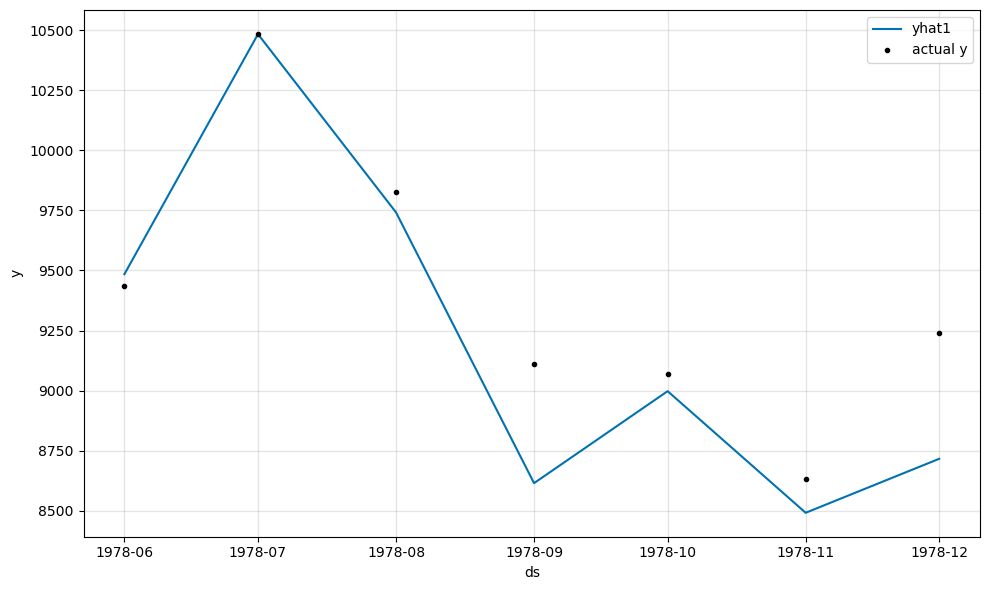

In [86]:
forecast = m.predict(df_test)
fig = m.plot(forecast)

In [87]:
forecast['yhat1']

0     9484.449219
1    10483.213867
2     9741.571289
3     8615.124023
4     8997.782227
5     8491.816406
6     8716.508789
Name: yhat1, dtype: float64

In [88]:
print(mean_squared_error(np.array(df_test['y']),forecast['yhat1'])**0.5)

281.307483111493


**Для предсказания на следующие 2 года обучим новую модель на всех известных данных.**

In [89]:
m_two_years_np = NeuralProphet(
    
#     seasonality_mode="multiplicative", 
    yearly_seasonality=True, 
    learning_rate=1,
    epochs=1000)
m_two_years_np.fit(dataset)
future = m_two_years_np.make_future_dataframe(dataset, periods=24)
forecast_np = m_two_years_np.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
Epoch[1000/1000]: 100%|█| 1000/1000 [00:08<00:00, 122.13it/s, SmoothL1Loss=0.001
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.278% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_u

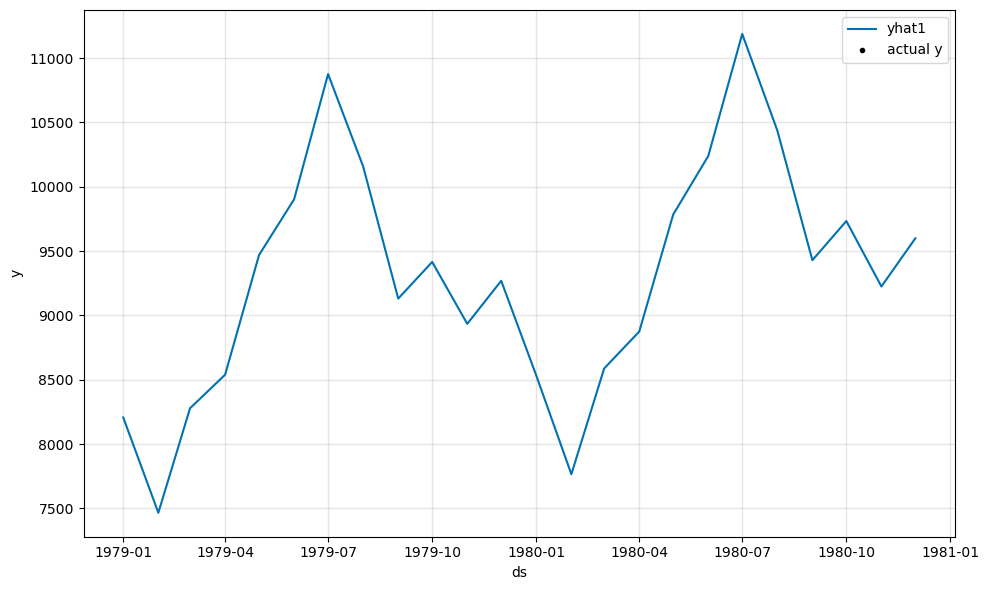

In [90]:
plot1 = m_two_years_np.plot(forecast_np)

In [91]:
sum(forecast_np['yhat1'])

223033.57275390625

---

# Prophet

In [92]:
from prophet import Prophet

In [93]:
train = dataset[:-24]

In [94]:
test = dataset[-24:]

In [95]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [96]:
future = m.make_future_dataframe(periods=24, freq='MS')
future.tail()

,ds
67,1978-08-01
68,1978-09-01
69,1978-10-01
70,1978-11-01
71,1978-12-01


In [97]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,1978-08-01,8789.476937,8500.140878,9109.407840
68,1978-09-01,7631.105943,7302.602218,7954.935623
69,1978-10-01,7900.571809,7592.292160,8232.646296
70,1978-11-01,7442.006783,7102.580722,7787.125683
71,1978-12-01,7397.226143,7063.566924,7752.832404


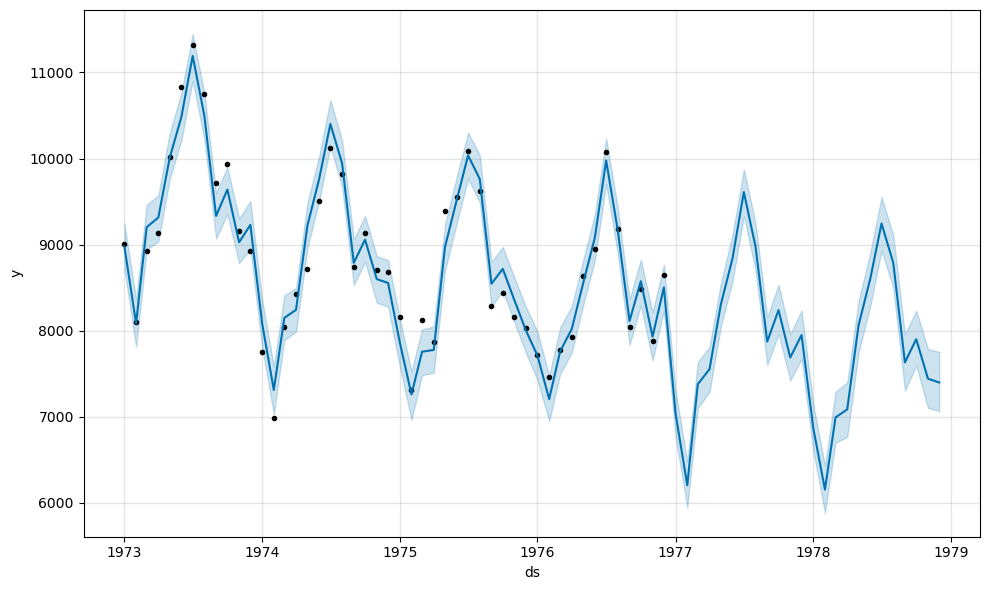

In [98]:
fig1 = m.plot(forecast)


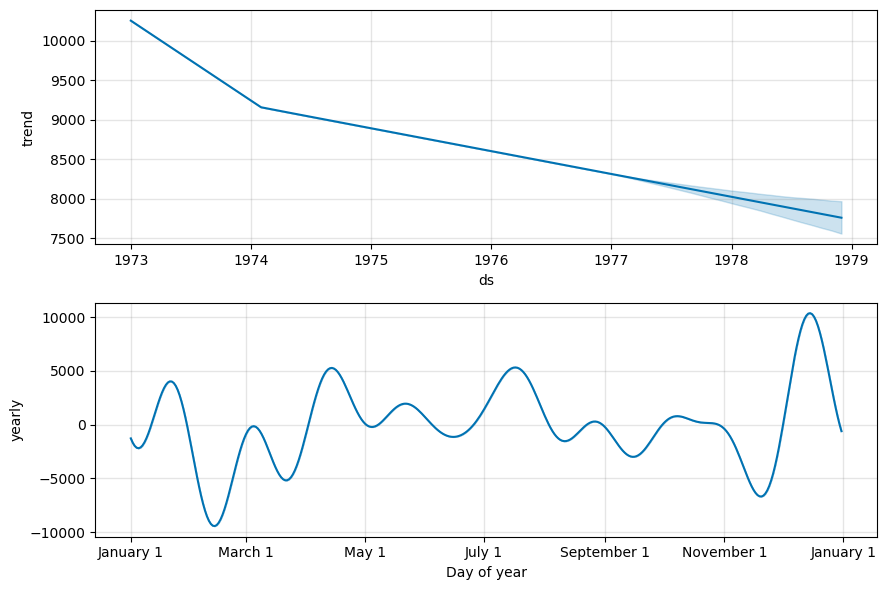

In [99]:
fig2 = m.plot_components(forecast)

In [100]:
print(mean_squared_error(np.array(test['y']),forecast['yhat'][-24:])**0.5)

932.7578721830087


**Предскажем значения на следующие 2 года. Для предсказания на следующие 2 года обучим новую модель на всех известных данных.**

In [101]:
m_two_years = Prophet()
m_two_years.fit(dataset)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [102]:
future_two_years = m_two_years.make_future_dataframe(periods=24, freq='MS')

In [103]:
forecast_two_years = m_two_years.predict(future_two_years)

In [104]:
(forecast_two_years['yhat'][-24:-23])

72    8130.664225
Name: yhat, dtype: float64

In [105]:
forecast_two_years = forecast_two_years['yhat'][-24:].reset_index()

In [106]:
forecast_two_years = forecast_two_years.drop('index', axis=1)

In [110]:
sum(forecast_two_years['yhat'])

221405.52423270166

# **Сравним предсказания всех моделей выше.**

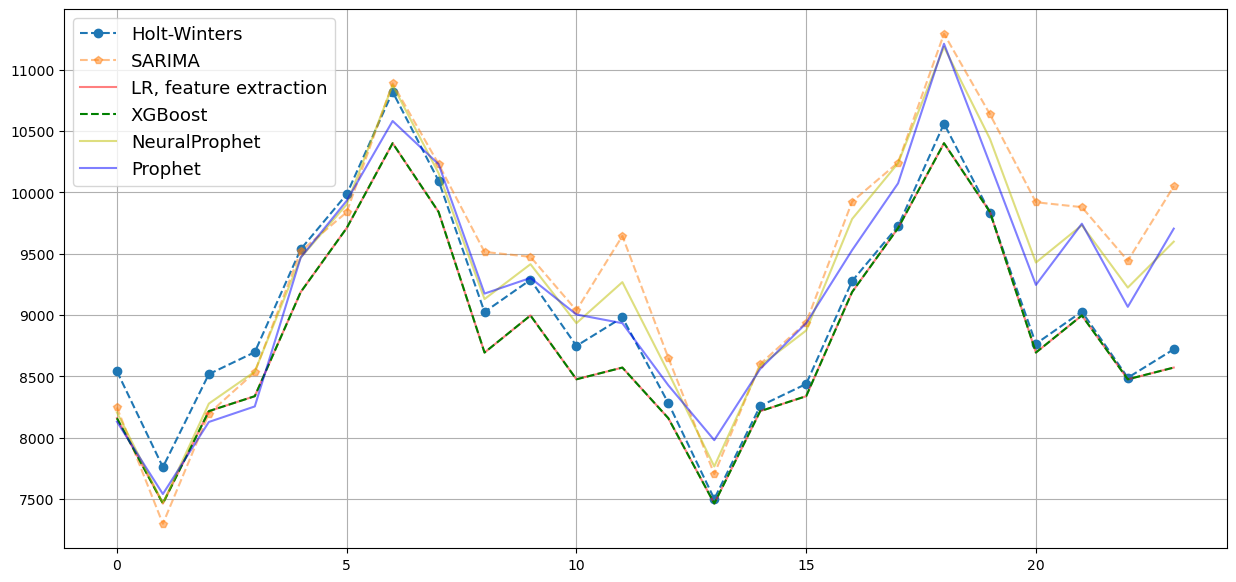

In [108]:
plt.figure(figsize=(15, 7))
plt.plot(prediction_hw, "o--", label = "Holt-Winters")
plt.plot(prediction_sarima, "p--", alpha=0.5, label = 'SARIMA')
plt.plot(prediction_two_years_lr, "r", alpha=0.5, label='LR, feature extraction')
plt.plot(prediction_two_years_xgb, "g--", alpha=1, label='XGBoost')
plt.plot(forecast_np['yhat1'], "y", alpha=0.5, label='NeuralProphet')
plt.plot(forecast_two_years, "b", alpha=0.5, label='Prophet')
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);